# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_025  Q9BQT9;Q9BQT9-2            18.739
Sample_171  P07093-2;P07093-3          15.406
Sample_066  P39060;P39060-1;P39060-2   20.194
Sample_173  G5E968                     15.207
Sample_184  Q16849                     19.174
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups            
Sample_194  P20138;P20138-2              13.192
Sample_148  O00451                       14.661
Sample_202  A0A0J9YW36;Q9NZ72;Q9NZ72-2   13.701
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.848
            A0A075B6Q5                 13.108
            A0A075B6R2                 12.672
            A0A075B6S5                 12.553
            A0A087WSY4                 12.134
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.095
            Q9UI40;Q9UI40-2            13.511
            Q9UIW2                     13.491
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.673
            Q9UP79                     12.966
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.088,15.050,16.842,19.863,15.897,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.795,19.067,...,15.528,15.576,13.907,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.956,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.253,17.705,17.039,16.113,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.312,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.498,15.345,17.084,18.708,14.249,19.433,11.317,11.050
Sample_207,15.739,16.877,15.469,16.898,14.851,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.848,...,16.012,15.178,13.429,15.050,16.842,19.863,12.955,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.814,19.067,16.188,...,15.528,15.576,12.891,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,11.237,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.550,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.061,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.029,15.345,17.084,18.708,14.249,19.433,13.122,11.692
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 453.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.03it/s]

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.28it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.51it/s]

100%|██████████| 4/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.17it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.50it/s]

100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.72it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.88it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.23it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.05it/s]

100%|██████████| 6/6 [00:02<00:00,  1.88it/s]

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.20it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.92it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.44it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.05it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.86it/s]

100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.78it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.79it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.46it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.38it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.31it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.27it/s]

100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.54it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.88it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.49it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.48it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.38it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.39it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.34it/s]

100%|██████████| 9/9 [00:02<00:00,  3.12it/s]

100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.72it/s]

 30%|███       | 3/10 [00:00<00:01,  4.19it/s]

 40%|████      | 4/10 [00:01<00:01,  3.64it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.25it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.07it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.07it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.16it/s]

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.74it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.53it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.88it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.63it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.60it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.28it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.96it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.43it/s]

100%|██████████| 11/11 [00:03<00:00,  2.23it/s]

100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.00it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.91it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.59it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.31it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.37it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.55it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.20it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.10it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.02it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.19it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

100%|██████████| 12/12 [00:05<00:00,  2.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.76it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.91it/s]

 31%|███       | 4/13 [00:00<00:02,  3.88it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.61it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.33it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.05it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.94it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.05it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.97it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.13it/s]

100%|██████████| 13/13 [00:05<00:00,  2.31it/s]

100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.21it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.41it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.95it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.48it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.90it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.79it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.52it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.64it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.76it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.64it/s]

100%|██████████| 14/14 [00:04<00:00,  2.70it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.07it/s]

 20%|██        | 3/15 [00:00<00:02,  4.29it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.96it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.95it/s]

 40%|████      | 6/15 [00:01<00:03,  2.60it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.10it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.26it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.48it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.53it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.69it/s]

100%|██████████| 15/15 [00:05<00:00,  2.74it/s]

100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.010          0.829 0.271       0.143   
2             0.004 0.002      0.060 0.022          0.650 0.096       0.568   
3             0.005 0.004      0.058 0.018          0.765 0.105       0.715   
4             0.007 0.005      0.085 0.017          0.779 0.100       0.740   
5             0.004 0.003      0.060 0.021          0.762 0.099       0.755   
6             0.005 0.004      0.057 0.020          0.762 0.099       0.755   
7             0.004 0.002      0.058 0.020          0.767 0.099       0.768   
8             0.007 0.005      0.073 0.025          0.823 0.088       0.800   
9             0.007 0.006      0.079 0.039          0.824 0.087       0.834   
10            0.005 0.003      0.062 0.021          0.827 0.084       0.817   
11            0.006 0.005      0.060 0.020          0.830 0.081       0.816   
12            0.005 0.004      0.063 0.031          0.826 0.077       0.825   
13            0.005 0.004      0.065 0.029          0.821 0.076       0.824   
14            0.004 0.002      0.052 0.013          0.823 0.074       0.824   
15            0.005 0.004      0.051 0.011          0.821 0.075       0.826   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.236 0.121                  0.563 0.041        0.861   
2          0.106   0.599 0.081                  0.669 0.058        0.727   
3          0.110   0.733 0.081                  0.774 0.067        0.875   
4          0.111   0.753 0.084                  0.790 0.068        0.888   
5          0.113   0.752 0.077                  0.787 0.065        0.890   
6          0.114   0.752 0.080                  0.788 0.067        0.889   
7          0.118   0.761 0.086                  0.796 0.072        0.888   
8          0.114   0.806 0.078                  0.836 0.064        0.915   
9          0.104   0.824 0.071                  0.850 0.061        0.913   
10         0.095   0.818 0.066                  0.844 0.056        0.927   
11         0.094   0.819 0.064                  0.846 0.054        0.925   
12         0.093   0.822 0.062                  0.848 0.053        0.924   
13         0.091   0.819 0.059                  0.845 0.051        0.922   
14         0.092   0.820 0.061                  0.846 0.052        0.921   
15         0.089   0.820 0.061                  0.846 0.052        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.086        210.000 0.000  
2          0.071                  0.653 0.084        210.000 0.000  
3          0.059                  0.833 0.079        210.000 0.000  
4          0.057                  0.864 0.067        210.000 0.000  
5          0.054                  0.863 0.066        210.000 0.000  
6          0.054                  0.861 0.066        210.000 0.000  
7          0.054                  0.862 0.066        210.000 0.000  
8          0.046                  0.898 0.055        210.000 0.000  
9          0.048                  0.902 0.053        210.000 0.000  
10         0.042                  0.918 0.044        210.000 0.000  
11         0.045                  0.915 0.047        210.000 0.000  
12         0.045                  0.915 0.047        210.000 0.000  
13         0.046                  0.913 0.048        210.000 0.000  
14         0.046                  0.912 0.048        210.000 0.000  
15         0.046                  0.910 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 475.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.66it/s]

100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.22it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.68it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.28it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.34it/s]

100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.97it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.99it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.45it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.56it/s]

100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.95it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.50it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.34it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.24it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.03it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.05it/s]

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.00it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.30it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.71it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.74it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.45it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.38it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.32it/s]

 30%|███       | 3/10 [00:01<00:02,  2.41it/s]

 40%|████      | 4/10 [00:01<00:02,  2.21it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.30it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.45it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.40it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.03it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.89it/s]

100%|██████████| 10/10 [00:04<00:00,  1.83it/s]

100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.36it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.32it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.88it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.61it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.71it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.41it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.16it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.12it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.21it/s]

100%|██████████| 11/11 [00:04<00:00,  2.41it/s]

100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.94it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.99it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.80it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.26it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.14it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.16it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.14it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.22it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.25it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.29it/s]

100%|██████████| 12/12 [00:04<00:00,  2.38it/s]

100%|██████████| 12/12 [00:04<00:00,  2.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.58it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.48it/s]

 31%|███       | 4/13 [00:01<00:04,  2.24it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.07it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.18it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.23it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.30it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.31it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.38it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.42it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.39it/s]

100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.03it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.91it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.76it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.66it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.55it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.49it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.37it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.39it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.45it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.40it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.46it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.56it/s]

100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.88it/s]

 20%|██        | 3/15 [00:00<00:03,  3.90it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.04it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.85it/s]

 40%|████      | 6/15 [00:01<00:03,  2.73it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.52it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.52it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.67it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.79it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.86it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.88it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.83it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.97it/s]

100%|██████████| 15/15 [00:05<00:00,  3.25it/s]

100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.066 0.026          0.010 0.071       0.001   
2             0.004 0.000      0.047 0.006          0.599 0.198       0.257   
3             0.004 0.003      0.058 0.019          0.733 0.113       0.518   
4             0.005 0.004      0.063 0.023          0.798 0.088       0.710   
5             0.006 0.004      0.061 0.023          0.788 0.097       0.724   
6             0.004 0.002      0.045 0.005          0.778 0.095       0.721   
7             0.005 0.003      0.055 0.019          0.780 0.102       0.728   
8             0.006 0.005      0.068 0.026          0.779 0.099       0.728   
9             0.006 0.006      0.074 0.028          0.797 0.096       0.746   
10            0.005 0.004      0.058 0.023          0.799 0.096       0.735   
11            0.004 0.001      0.042 0.010          0.799 0.088       0.787   
12            0.004 0.002      0.043 0.013          0.802 0.085       0.795   
13            0.004 0.004      0.044 0.011          0.806 0.083       0.796   
14            0.003 0.001      0.040 0.007          0.803 0.083       0.757   
15            0.004 0.001      0.050 0.023          0.804 0.089       0.771   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.854   
2          0.119   0.342 0.129                  0.565 0.043        0.689   
3          0.095   0.601 0.083                  0.688 0.056        0.701   
4          0.117   0.746 0.086                  0.788 0.066        0.887   
5          0.117   0.749 0.087                  0.789 0.068        0.889   
6          0.116   0.743 0.086                  0.784 0.068        0.887   
7          0.103   0.749 0.085                  0.788 0.068        0.898   
8          0.106   0.748 0.085                  0.787 0.068        0.896   
9          0.101   0.767 0.083                  0.802 0.068        0.896   
10         0.104   0.762 0.084                  0.799 0.068        0.895   
11         0.115   0.788 0.082                  0.820 0.068        0.911   
12         0.104   0.793 0.073                  0.824 0.060        0.913   
13         0.103   0.796 0.073                  0.827 0.061        0.912   
14         0.109   0.774 0.075                  0.810 0.061        0.914   
15         0.112   0.782 0.080                  0.816 0.066        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.087        210.000 0.000  
2          0.096                  0.603 0.113        210.000 0.000  
3          0.072                  0.708 0.082        210.000 0.000  
4          0.046                  0.857 0.062        210.000 0.000  
5          0.051                  0.857 0.066        210.000 0.000  
6          0.050                  0.854 0.066        210.000 0.000  
7          0.052                  0.869 0.067        210.000 0.000  
8          0.053                  0.867 0.067        210.000 0.000  
9          0.055                  0.871 0.068        210.000 0.000  
10         0.054                  0.868 0.068        210.000 0.000  
11         0.047                  0.887 0.057        210.000 0.000  
12         0.046                  0.893 0.054        210.000 0.000  
13         0.047                  0.891 0.056        210.000 0.000  
14         0.046                  0.892 0.054        210.000 0.000  
15         0.044                  0.892 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 962.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.42it/s]

100%|██████████| 2/2 [00:00<00:00, 18.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.68it/s]

100%|██████████| 3/3 [00:00<00:00, 20.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.77it/s]

100%|██████████| 4/4 [00:00<00:00, 18.44it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.80it/s]

100%|██████████| 5/5 [00:00<00:00, 14.85it/s]

100%|██████████| 5/5 [00:00<00:00, 14.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 29.01it/s]

100%|██████████| 6/6 [00:00<00:00, 22.56it/s]

100%|██████████| 6/6 [00:00<00:00, 23.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.00it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.26it/s]

100%|██████████| 7/7 [00:00<00:00, 17.51it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.60it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 17.52it/s]

100%|██████████| 8/8 [00:00<00:00, 16.41it/s]

100%|██████████| 8/8 [00:00<00:00, 17.05it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 23.27it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.05it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.41it/s]

100%|██████████| 9/9 [00:00<00:00, 17.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.47it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.92it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.92it/s]

100%|██████████| 10/10 [00:00<00:00, 15.84it/s]

100%|██████████| 10/10 [00:00<00:00, 16.37it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 28.25it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 20.22it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 17.77it/s]

100%|██████████| 11/11 [00:00<00:00, 16.84it/s]

100%|██████████| 11/11 [00:00<00:00, 17.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.70it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.41it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.67it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.34it/s]

100%|██████████| 12/12 [00:00<00:00, 16.68it/s]

100%|██████████| 12/12 [00:00<00:00, 16.94it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.08it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.63it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 18.86it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 17.56it/s]

100%|██████████| 13/13 [00:00<00:00, 17.38it/s]

100%|██████████| 13/13 [00:00<00:00, 18.16it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 25.47it/s]

 43%|████▎     | 6/14 [00:00<00:00, 18.21it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 17.77it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 17.56it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 17.29it/s]

100%|██████████| 14/14 [00:00<00:00, 17.18it/s]

100%|██████████| 14/14 [00:00<00:00, 17.77it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.43it/s]

 40%|████      | 6/15 [00:00<00:00, 17.25it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.34it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.06it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.98it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 16.19it/s]

100%|██████████| 15/15 [00:00<00:00, 16.57it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.045 0.013          0.000 0.000       0.000   
2             0.003 0.003      0.040 0.014          0.020 0.141       0.001   
3             0.005 0.003      0.054 0.019          0.659 0.111       0.532   
4             0.003 0.002      0.045 0.016          0.654 0.114       0.525   
5             0.002 0.001      0.030 0.008          0.697 0.113       0.538   
6             0.004 0.002      0.045 0.006          0.691 0.097       0.554   
7             0.003 0.002      0.038 0.010          0.690 0.101       0.562   
8             0.003 0.002      0.035 0.012          0.678 0.107       0.550   
9             0.004 0.002      0.047 0.006          0.683 0.111       0.557   
10            0.003 0.001      0.033 0.012          0.655 0.104       0.581   
11            0.004 0.002      0.040 0.008          0.649 0.097       0.584   
12            0.004 0.001      0.042 0.012          0.650 0.099       0.593   
13            0.004 0.000      0.048 0.011          0.649 0.105       0.589   
14            0.003 0.001      0.039 0.008          0.646 0.099       0.598   
15            0.003 0.001      0.037 0.009          0.656 0.093       0.599   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.744   
2          0.008   0.002 0.016                  0.500 0.006        0.586   
3          0.113   0.582 0.093                  0.663 0.066        0.752   
4          0.116   0.575 0.096                  0.658 0.068        0.747   
5          0.116   0.598 0.091                  0.680 0.061        0.759   
6          0.125   0.604 0.093                  0.684 0.058        0.766   
7          0.122   0.610 0.091                  0.686 0.059        0.763   
8          0.125   0.597 0.094                  0.676 0.061        0.757   
9          0.119   0.605 0.095                  0.681 0.065        0.760   
10         0.110   0.609 0.086                  0.676 0.063        0.766   
11         0.110   0.608 0.083                  0.674 0.060        0.762   
12         0.109   0.613 0.083                  0.676 0.061        0.760   
13         0.109   0.609 0.086                  0.673 0.064        0.755   
14         0.111   0.614 0.085                  0.676 0.069        0.759   
15         0.110   0.620 0.083                  0.682 0.065        0.758   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.688 0.084        210.000 0.000  
2          0.115                  0.570 0.108        210.000 0.000  
3          0.067                  0.705 0.081        210.000 0.000  
4          0.067                  0.701 0.080        210.000 0.000  
5          0.066                  0.717 0.078        210.000 0.000  
6          0.064                  0.727 0.076        210.000 0.000  
7          0.065                  0.725 0.079        210.000 0.000  
8          0.065                  0.720 0.078        210.000 0.000  
9          0.066                  0.716 0.084        210.000 0.000  
10         0.063                  0.718 0.081        210.000 0.000  
11         0.063                  0.720 0.085        210.000 0.000  
12         0.066                  0.720 0.085        210.000 0.000  
13         0.067                  0.715 0.085        210.000 0.000  
14         0.069                  0.724 0.085        210.000 0.000  
15         0.069                  0.721 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,4,9,3
score_time,4,9,3
test_precision,11,13,5
test_recall,9,13,15
test_f1,9,13,15
test_balanced_accuracy,9,13,7
test_roc_auc,10,15,10
test_average_precision,10,12,6
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.95it/s]

 20%|██        | 3/15 [00:00<00:02,  5.08it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.82it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.69it/s]

 40%|████      | 6/15 [00:01<00:01,  4.63it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.55it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.37it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.54it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.55it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.62it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.59it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.53it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.56it/s]

100%|██████████| 15/15 [00:03<00:00,  3.91it/s]

100%|██████████| 15/15 [00:03<00:00,  4.46it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 27.17it/s]

 60%|██████    | 6/10 [00:00<00:00, 21.71it/s]

 90%|█████████ | 9/10 [00:00<00:00, 21.09it/s]

100%|██████████| 10/10 [00:00<00:00, 21.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.51it/s]

 30%|███       | 3/10 [00:00<00:00,  7.01it/s]

 40%|████      | 4/10 [00:00<00:00,  6.15it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.74it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.52it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.53it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.54it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.54it/s]

100%|██████████| 10/10 [00:01<00:00,  4.48it/s]

100%|██████████| 10/10 [00:01<00:00,  5.08it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


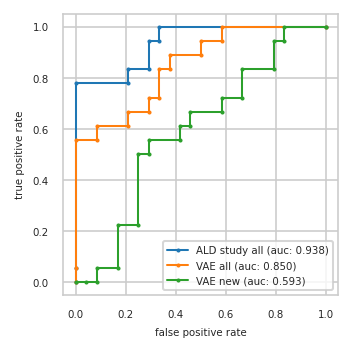

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.778   0.000 0.556   0.083 0.000
3          0.208 0.778   0.083 0.556   0.083 0.056
4          0.208 0.833   0.083 0.611   0.167 0.056
5          0.292 0.833   0.208 0.611   0.167 0.222
6          0.292 0.944   0.208 0.667   0.250 0.222
7          0.333 0.944   0.292 0.667   0.250 0.500
8          0.333 1.000   0.292 0.722   0.292 0.500
9          1.000 1.000   0.333 0.722   0.292 0.556
10           NaN   NaN   0.333 0.833   0.417 0.556
11           NaN   NaN   0.375 0.833   0.417 0.611
12           NaN   NaN   0.375 0.889   0.458 0.611
13           NaN   NaN   0.500 0.889   0.458 0.667
14           NaN   NaN   0.500 0.944   0.583 0.667
15           NaN   NaN   0.583 0.944   0.583 0.722
16           NaN   NaN   0.583 1.000   0.667 0.722
17           NaN   NaN   1.000 1.000   0.667 0.833
18           NaN   NaN     NaN   NaN   0.792 0.833
19           NaN   NaN     NaN   NaN   0.792 0.944
20           NaN   NaN     NaN   NaN   0.833 0.944
21           NaN   NaN     NaN   NaN   0.833 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NBI6,B8ZZ19;H0Y3U0;P20472,P16519;P16519-3
2,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,F5GWQ8;J3QKW8;Q15846,Q9UMX0;Q9UMX0-2;Q9UMX0-4
3,P14174,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P61981,P61981,P31321
5,P04075,P04075,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P14174,P51674;P51674-2;P51674-3
7,P00338;P00338-3,P63104,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
8,C9JF17;P05090,P00492,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


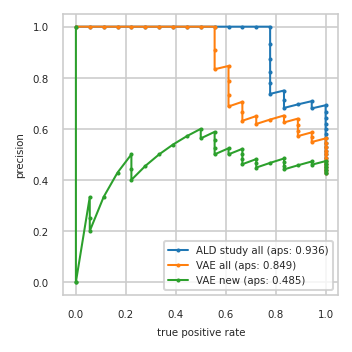

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.643 1.000     0.571 0.889     0.464 0.722
15         0.667 1.000     0.593 0.889     0.481 0.722
16         0.692 1.000     0.615 0.889     0.462 0.667
17         0.680 0.944     0.640 0.889     0.480 0.667
18         0.708 0.944     0.625 0.833     0.500 0.667
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.682 0.833     0.636 0.778     0.500 0.611
21         0.714 0.833     0.619 0.722     0.524 0.611
22         0.750 0.833     0.650 0.722     0.500 0.556
23         0.737 0.778     0.632 0.667     0.526 0.556
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.875 0.778     0.688 0.611     0.562 0.500
27         0.933 0.778     0.733 0.611     0.600 0.500
28         1.000 0.778     0.786 0.611     0.571 0.444
29         1.000 0.722     0.846 0.611     0.538 0.389
30         1.000 0.667     0.833 0.556     0.500 0.333
31         1.000 0.611     0.909 0.556     0.455 0.278
32         1.000 0.556     1.000 0.556     0.400 0.222
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.200 0.056
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


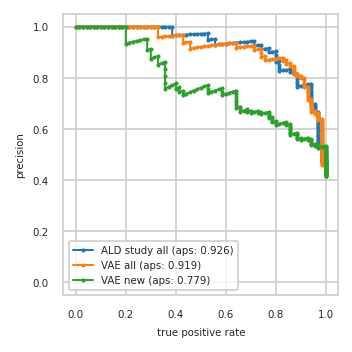

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


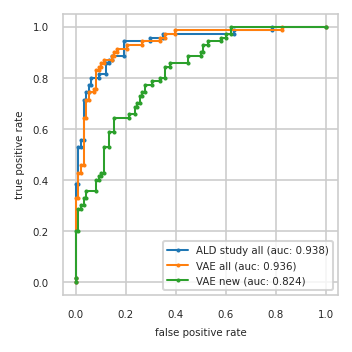

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}